In [19]:
import os

os.environ["USE_PYGEOS"] = "0"

import datacube
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from odc.ui import DcViewer
from datacube.utils import masking
from datacube.utils.cog import write_cog
from datacube.utils.rio import configure_s3_access

from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

/env/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36763 instead
  warnings.warn(


In [2]:
dc = datacube.Datacube(app='sampleo') 

In [76]:
mr = gpd.read_file("vectores/muestreo_regular_300m.shp")
ma = gpd.read_file("vectores/muestreo_aleatorio.shp")

In [3]:
cuencas = gpd.read_file("vectores/Cuencas_BNA.shp")
cuenca = cuencas.loc[cuencas.COD_CUEN == "070"]
x0, y0, x1, y1 = cuenca.to_crs(4326).bounds.values[0]

In [17]:
query = {
    "product": ["landcover_chile_2014"],
    "y": (y0, y1), 
    "x": (x0, x1),
    "time": ("2014-01-01", "2020-12-31"),
    "output_crs": "EPSG:32719",
    "resolution": (-30, 30),
    "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
    # "group_by": "solar_day"
}

lc = dc.load(**query).squeeze()
lc

<xarray.Dataset>
Dimensions:      (y: 1019, x: 1434)
Coordinates:
    time         datetime64[ns] 2014-12-31
  * y            (y) float64 6.156e+06 6.156e+06 ... 6.125e+06 6.125e+06
  * x            (x) float64 2.08e+05 2.081e+05 2.081e+05 ... 2.51e+05 2.51e+05
    spatial_ref  int32 32719
Data variables:
    nivel_1      (y, x) uint16 dask.array<chunksize=(1019, 1434), meta=np.ndarray>
    nivel_2      (y, x) uint16 dask.array<chunksize=(1019, 1434), meta=np.ndarray>
    nivel_3      (y, x) uint16 dask.array<chunksize=(1019, 1434), meta=np.ndarray>
Attributes:
    crs:           epsg:32719
    grid_mapping:  spatial_ref

In [5]:
np.unique(lc.nivel_1.values)

array([   0,  100,  200,  300,  400,  500,  600,  800,  900, 1000],
      dtype=uint16)

In [21]:
write_cog(lc.nivel_1, "land_cover_2014_070.tif").compute()

PosixPath('land_cover_2014_070.tif')

<Axes: title={'center': 'time = 2014-12-31 [seconds since 1970-01-01 00:...'}, xlabel='x [metre]', ylabel='y [metre]'>

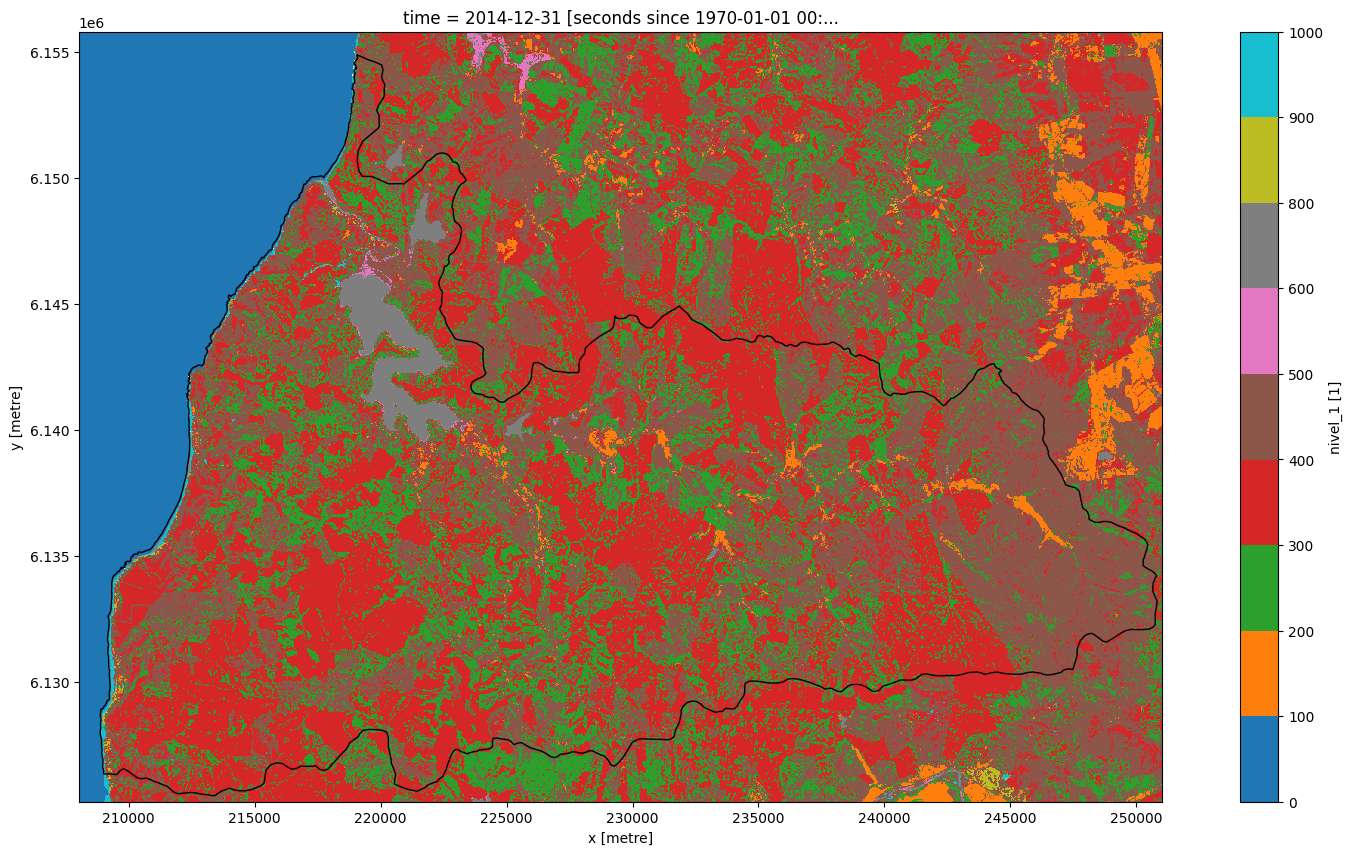

In [6]:
fig = plt.figure(figsize=(20,10))
ax_ = fig.add_subplot(111)

lc.nivel_1.plot(cmap="tab10", levels=[0, 100, 200, 300, 400, 500, 600, 800, 900, 1000], ax=ax_)
cuenca.plot(ax=ax_, facecolor='none', edgecolor='black')

In [7]:
query["product"] = "landsat8_c2l2_sr"
ds = dc.load(**query)
ds

<xarray.Dataset>
Dimensions:      (time: 280, y: 1019, x: 1434)
Coordinates:
  * time         (time) datetime64[ns] 2014-01-09T14:35:20.781400 ... 2020-12...
  * y            (y) float64 6.156e+06 6.156e+06 ... 6.125e+06 6.125e+06
  * x            (x) float64 2.08e+05 2.081e+05 2.081e+05 ... 2.51e+05 2.51e+05
    spatial_ref  int32 32719
Data variables:
    coastal      (time, y, x) uint16 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
    swir16       (time, y, x) uint16 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
    swir22       (time, y, x) uint16 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
    qa_pixel     (time, y, x) uint16 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
    qa_aerosol   (time, y, x) uint8 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
    qa_radsat    (time, y, x) uint16 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
Attributes:
    crs:           epsg:32719
    grid_mapping:  spatial_ref

In [13]:
quality_band = 'qa_pixel'
refl_bands = ["red", "nir08"]
cloud_free_mask = (
    masking.make_mask(ds[quality_band], snow='high_confidence') + 
    masking.make_mask(ds[quality_band], cloud="high_confidence") +
    masking.make_mask(ds[quality_band], cirrus="high_confidence") +
    masking.make_mask(ds[quality_band], cloud_shadow="high_confidence") +
    masking.make_mask(ds[quality_band], nodata=True)
)
dsf = xr.where(cloud_free_mask, np.nan, ds[refl_bands])
dsf.update(dsf * 0.0000275 + -0.2)
dsf.update(dsf.where(dsf >= 0).where(dsf <= 1))

<xarray.Dataset>
Dimensions:      (time: 280, y: 1019, x: 1434)
Coordinates:
  * time         (time) datetime64[ns] 2014-01-09T14:35:20.781400 ... 2020-12...
  * y            (y) float64 6.156e+06 6.156e+06 ... 6.125e+06 6.125e+06
  * x            (x) float64 2.08e+05 2.081e+05 2.081e+05 ... 2.51e+05 2.51e+05
    spatial_ref  int32 32719
Data variables:
    red          (time, y, x) float64 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
    nir08        (time, y, x) float64 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>

In [14]:
ndvi = (dsf['nir08'] - dsf['red']) / (dsf['nir08'] + dsf['red'])
ndvi.attrs = ds.attrs
ndvi

<xarray.DataArray (time: 280, y: 1019, x: 1434)>
dask.array<truediv, shape=(280, 1019, 1434), dtype=float64, chunksize=(1, 1019, 1434), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2014-01-09T14:35:20.781400 ... 2020-12...
  * y            (y) float64 6.156e+06 6.156e+06 ... 6.125e+06 6.125e+06
  * x            (x) float64 2.08e+05 2.081e+05 2.081e+05 ... 2.51e+05 2.51e+05
    spatial_ref  int32 32719
Attributes:
    crs:           epsg:32719
    grid_mapping:  spatial_ref

> Observe como funciona el cluster en el link: https://hub.datacubechile.cl/user/MI_USUARIO/proxy/8787/status (reemplace MI_USUARIO por su nombre de usuario)

In [15]:
ndvi = ndvi.compute()
ndvi

<xarray.DataArray (time: 280, y: 1019, x: 1434)>
array([[[        nan,         nan,         nan, ...,  0.29349116,
          0.29707913,  0.31194861],
        [        nan,         nan,         nan, ...,  0.31852349,
          0.32133959,  0.32317563],
        [        nan,         nan,         nan, ...,  0.32126108,
          0.31323102,  0.33936128],
        ...,
        [        nan,         nan,         nan, ...,  0.63310955,
          0.66851782,  0.6761705 ],
        [        nan,         nan,         nan, ...,  0.73410878,
          0.70688877,  0.70782375],
        [        nan,         nan,         nan, ...,  0.67018817,
          0.64514   ,  0.73577463]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.84202627,         nan,         nan, ...,  0.37376677,
          0.33042659,  0.29111228],
        [        nan,         nan,         nan, ...,  0.34223024,
          0.33782124,  0.31457897],
        [        nan,         nan,         nan, ...,  0.34116563,
          0.35718779,  0.28698643]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,  0.36997336,
          0.31635479,  0.28475915],
        [        nan,         nan,         nan, ...,  0.33432313,
          0.33389662,  0.30748989],
        [        nan,         nan,         nan, ...,  0.33648977,
          0.33942605,  0.29861688]]])
Coordinates:
  * time         (time) datetime64[ns] 2014-01-09T14:35:20.781400 ... 2020-12...
  * y            (y) float64 6.156e+06 6.156e+06 ... 6.125e+06 6.125e+06
  * x            (x) float64 2.08e+05 2.081e+05 2.081e+05 ... 2.51e+05 2.51e+05
    spatial_ref  int32 32719
Attributes:
    crs:           epsg:32719
    grid_mapping:  spatial_ref

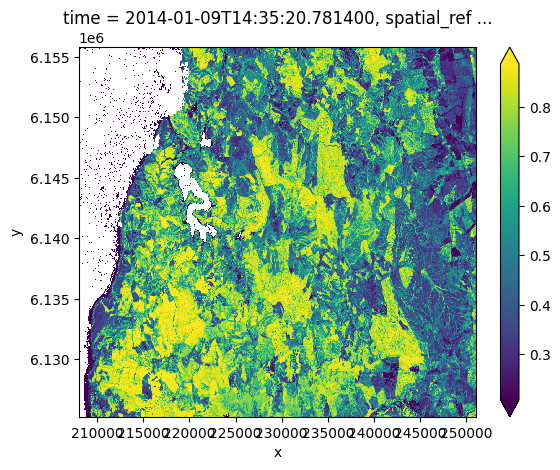

In [16]:
ndvi.isel(time=0).plot(robust=True)